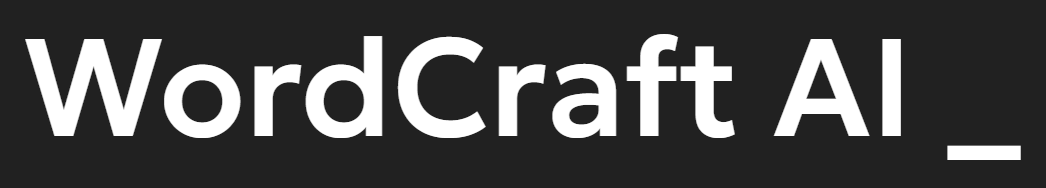

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
import json

import ipywidgets as widgets
from IPython.display import display

from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.model_selection import train_test_split

## Загрузка датасета

In [5]:
def load_dataset(csv_file_path):
  df = pd.read_csv(csv_file_path, header=0, sep = "\t")
  words_column = df.iloc[:, 0]
  words = [word.lower() for word in words_column.tolist()]

  return words

In [6]:
csv_file_path = 'nouns.csv'
full_dataset = load_dataset(csv_file_path)

print(full_dataset[:10])
print(len(full_dataset))

['человек', 'год', 'время', 'рука', 'стать', 'дело', 'раз', 'глаз', 'день', 'жизнь']
26982


## Анализ датасета

In [7]:
df = pd.DataFrame({'word': full_dataset})
df['word_length'] = df['word'].apply(len)
df

,word,word_length
0,человек,7
1,год,3
2,время,5
3,рука,4
4,стать,5
...,...,...
26977,ссыкуха,7
26978,туроператор,11
26979,валенок,7
26980,бабло,5


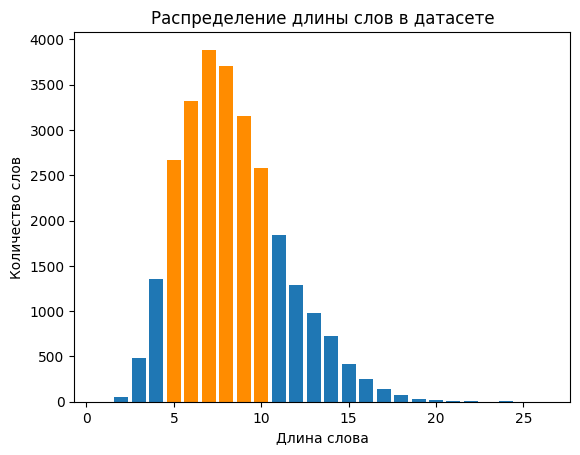

In [254]:
plt.hist(df['word_length'], bins=range(1, max(df['word_length']) + 2), align='left', rwidth=0.8)
plt.hist(df['word_length'][(df['word_length'] >= 5) & (df['word_length'] <= 10)], bins=range(1, max(df['word_length']) + 2), align='left', rwidth=0.8, color='darkorange')
plt.xlabel('Длина слова')
plt.ylabel('Количество слов')
plt.title('Распределение длины слов в датасете')
plt.show()

## Фильтрация датасета

In [6]:
min_word_length = 5
max_word_length = 10

In [149]:
# Ограничивает длину слов, оставляет только слова из букв, убирает дубликаты, исключает слова с одинаковыми подряд идущими символами
def filter_dataset(dataset, min_length, max_length):
  russian_alphabet_pattern = re.compile('[а-яё]+')
  unique_words = set()

  for word in dataset:
    if (min_length <= len(word) <= max_length and
        russian_alphabet_pattern.fullmatch(word) and
        word not in unique_words and
        not any((char1 == char2) for char1, char2 in zip(word, word[1:]))):
      unique_words.add(word)

  return list(unique_words)

In [150]:
dataset = filter_dataset(full_dataset, min_word_length, max_word_length)

len(dataset)

18283

## Подготовка данных для модели

In [4]:
alphabet = ' абвгдеёжзийклмнопрстуфхцчшщъыьэюя'

In [153]:
# Создание входных и выходных данных для нейросети
X_data = []
y_data = []

for word in dataset:
    for i in range(1, len(word)):
        input_sequence = word[:i]
        output_sequence = word[i:]
        X_data.append(input_sequence)
        y_data.append(output_sequence)

In [154]:
len(X_data)

117863

In [155]:
X_data[:9]

['п', 'па', 'пак', 'пако', 'пакос', 'пакост', 'д', 'до', 'доп']

In [156]:
y_data[:9]

['акость', 'кость', 'ость', 'сть', 'ть', 'ь', 'опущение', 'пущение', 'ущение']

In [5]:
# Создание словарей для отображения символов в индексы и обратно
char_to_index = {char: idx for idx, char in enumerate(alphabet)}
index_to_char = {idx: char for idx, char in enumerate(alphabet)}

In [7]:
vector_len = max_word_length - 1
vector_len

9

In [13]:
# Создает one-hot вектор для символа
def char_to_one_hot(char):
  one_hot_vector = np.zeros(len(alphabet), dtype=int)
  if char in alphabet:
    one_hot_vector[alphabet.index(char)] = 1

  return one_hot_vector.tolist()

In [14]:
# Создает матричное представление для слова
def word_to_vector(word):
  padded_word = word.ljust(vector_len, ' ')

  return [char_to_one_hot(char) for char in padded_word]

In [161]:
# Преобразование входных и выходных данных в матричный формат
X_encoded = [word_to_vector(word_beginning) for word_beginning in X_data]
y_encoded = [word_to_vector(word_continuation) for word_continuation in y_data]

X_encoded = np.array(X_encoded)
y_encoded = np.array(y_encoded)

In [163]:
print(X_encoded[3])
print(X_encoded[3].shape)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(9, 34)


In [182]:
# Деление на тренировачную и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.1)

X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'Train: {len(X_train)}')
print(f'Test: {len(X_test)}')

Train: 106076
Test: 11787


## Создание модели генератора

In [232]:
# Создание модели
model = Sequential()
model.add(LSTM(50, input_shape=(vector_len, len(alphabet)), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(vector_len*len(alphabet), activation="softmax"))
model.add(Reshape((vector_len, len(alphabet))))

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

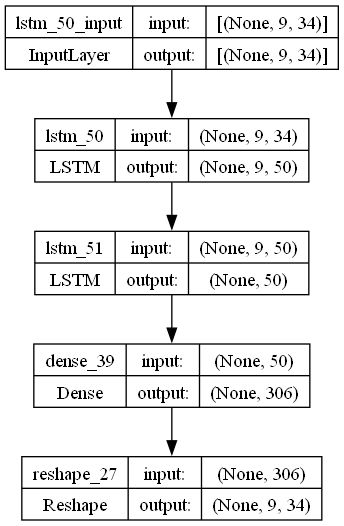

In [255]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Обучение модели

In [234]:
# Обучение модели
early_stopping = EarlyStopping(monitor='accuracy', patience=5)
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
model.save(f'generator_{current_datetime}.keras', overwrite=True)

Epoch 1/500
3315/3315 [==============================] - 14s 4ms/step - loss: 1.6259 - accuracy: 0.5826 - val_loss: 1.5377 - val_accuracy: 0.5883
Epoch 2/500
3315/3315 [==============================] - 12s 4ms/step - loss: 1.5245 - accuracy: 0.5909 - val_loss: 1.5208 - val_accuracy: 0.5903
Epoch 3/500
3315/3315 [==============================] - 11s 3ms/step - loss: 1.4927 - accuracy: 0.5967 - val_loss: 1.4756 - val_accuracy: 0.5985
Epoch 4/500
3315/3315 [==============================] - 11s 3ms/step - loss: 1.4570 - accuracy: 0.6033 - val_loss: 1.4558 - val_accuracy: 0.6028
Epoch 5/500
3315/3315 [==============================] - 11s 3ms/step - loss: 1.4416 - accuracy: 0.6064 - val_loss: 1.4437 - val_accuracy: 0.6051
Epoch 6/500
3315/3315 [==============================] - 11s 3ms/step - loss: 1.4291 - accuracy: 0.6089 - val_loss: 1.4315 - val_accuracy: 0.6083
Epoch 7/500
3315/3315 [==============================] - 11s 3ms/step - loss: 1.4167 - accuracy: 0.6112 - val_loss: 1.4208 -

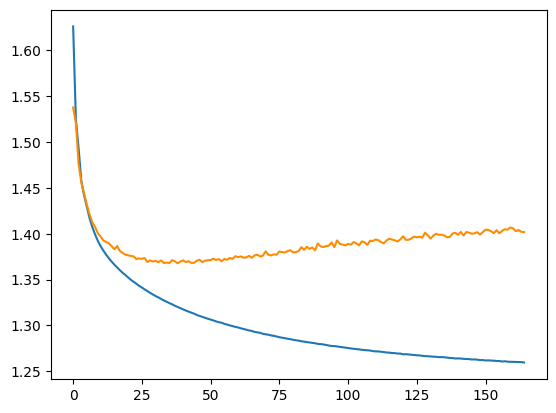

In [235]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='darkorange')

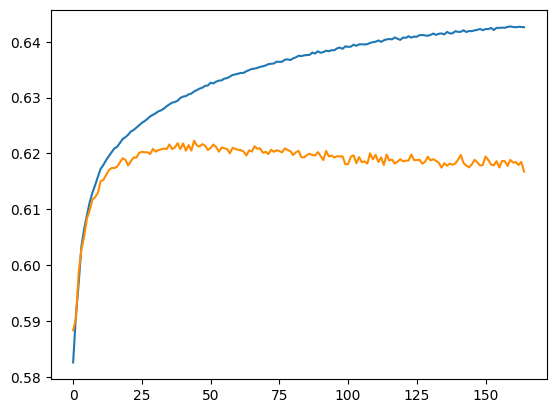

In [236]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='darkorange')

## Тестирование

In [2]:
loaded_model = load_model('generator_20231206_134216.keras')

In [8]:
# Преобразует матричное представление обратно в слово
def vector_to_word(vector):
  word = ''
  for v in vector:
    idx = np.argmax(np.array(v))
    if idx == 0:  break
    word += index_to_char[idx]

  return word

In [9]:
def get_predictions(inputs):
  input_vectors = [word_to_vector(word_beginning) for word_beginning in inputs]
  predictions = loaded_model.predict(np.array(input_vectors))
  word_continuations = [vector_to_word(prediction) for prediction in predictions]

  return word_continuations

In [10]:
def print_prediction(inputs):
  word_continuations = get_predictions(inputs)
  for word_beginning, word_continuation in zip(inputs, word_continuations):
    print(f'{word_beginning}: {word_continuation}')

In [11]:
test_inputs = ['пр', 'авт', 'че', 'само', 'ст', 'тел', 'поз', 'cл', 'а', 'гла', 'окр', 'дере', 'огуре']

In [15]:
print_prediction(test_inputs)

1/1 [==============================] - 1s 655ms/step
пр: осор
авт: опаа
че: рнон
само: вор
ст: ароа
тел: ена
поз: орн
cл: оноа
а: нтор
гла: зин
окр: авк
дере: вен
огуре: н


In [17]:
def generate_text(input_text):
  word_continuation = get_predictions([input_text])[0]
  return input_text + word_continuation

# Текстовое поле ввода
input_text = widgets.Text(description='Input:')

# Текстовое поле вывода
output_text = widgets.Text(description='Output:', disabled=True)

# Функция, которая вызывается при изменении текста в поле ввода
def on_input_change(change):
  user_input = change['new']
  generated_text = generate_text(user_input)
  output_text.value = generated_text

input_text.observe(on_input_change, names='value')

display(input_text, output_text)

Text(value='', description='Input:')

Text(value='', description='Output:', disabled=True)

## Сохранение результатов

In [292]:
def generate_word_beginnings(dataset):
  word_beginnings = []
  for word in dataset:
    for i in range(1, 4):
      word_beginnings.append(word[:i])

  word_beginnings_set = set(word_beginnings)
  word_beginnings = list(word_beginnings_set)
  word_beginnings.sort()

  return word_beginnings

In [293]:
dataset_for_json = filter_dataset(full_dataset, 4, 13)

inputs = generate_word_beginnings(dataset_for_json)
outputs = get_predictions(inputs)

data = []

for inp, outp in zip(inputs, outputs):
  entry = {"Input": inp, "Output": outp, "Result": inp+outp}
  data.append(entry)

with open("generator_result.json", "w", encoding="utf-8") as json_file:
  json.dump(data, json_file, ensure_ascii=False, indent=2)

103/103 [==============================] - 0s 2ms/step
